In [290]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString , Polygon, mapping, shape

import csv
from pathlib import Path

import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from rasterstats import zonal_stats

from descartes import PolygonPatch

import geojson

from fiona import collection
import fiona

import geoplot 

from shape_generator import select_raster_file

## Setting up the data files

In [247]:
#checking package versions - learned this was very important as I had repeated mask errors with an older version of rasterio
rasterio.gdal_version()
#previously had an old version and needed to update- 3.0.4 used by Omdena team

'3.1.2'

In [248]:
from platform import python_version
#previously had 3.5 and needed to update to accomodate the updated rasterio
print(python_version())

3.7.7


In [170]:
# reading in the Gridded Population of the World dataset
raster_file= rasterio.open('/Users/jswee/Documents/OFDA/Data Model/Population Data/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif')
print(raster_file)

<open DatasetReader name='/Users/jswee/Documents/OFDA/Data Model/Population Data/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif' mode='r'>


In [171]:
# reading in the Gridded Population of the World dataset
data_folder = Path.cwd().parent.parent.joinpath('datasets', 'Gridded Population of the World (GPW)')
#print(data_folder)
input_filename = 'gpw_v4_population_count_rev11_2015_30_sec.tif'
input_raster_file = Path(data_folder).joinpath(input_filename)
print(input_raster_file)

C:\Users\jswee\datasets\Gridded Population of the World (GPW)\gpw_v4_population_count_rev11_2015_30_sec.tif


In [173]:
#Explore population tif data
print("count: {}".format(raster_file.count)) # Raster bands
print("height(rows): {}".format(raster_file.height)) # Rows (rows)
print("width(columns): {}".format(raster_file.width)) # Columns

count: 1
height(rows): 21600
width(columns): 43200


In [289]:
raster_file.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999999983, top=89.99999999999991)

In [175]:
{i: dtype for i, dtype in zip(raster_file.indexes, raster_file.dtypes)}

{1: 'float32'}

In [176]:
#Unsure if this is needed but used in many examples - our floods already have countries associated with
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# get the countries associated for the geometry boundary's
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [177]:
world.crs

{'init': 'epsg:4326'}

In [178]:
# reading in the flood data
df_input = pd.read_csv("/Users/jswee/Documents/OFDA/Data Model/FloodsArchived/FloodArchive.csv")  
df_input

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity
0,1,0,Algeria,0,5.23026,35.81420,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0
1,2,0,Brazil,0,-45.34890,-18.71110,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0
2,3,0,Phillipines,0,122.97400,10.02070,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0
3,4,0,Indonesia,0,124.60600,1.01489,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0
4,5,0,Mozambique,0,32.34910,-25.86930,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,4947,NaN,Niger,Mali,1.16086,15.53690,390094.45,7/1/2020,7/30/2020,FloodList,9,15000,Heavy Rain,1.5
4946,4948,NaN,South Korea,NaN,127.05600,36.34890,23218.80,7/29/2020,7/30/2020,FloodList,2,0,Torrential Rain,1.5
4947,4950,NaN,Myanmar,NaN,96.26250,23.17430,46562.48,7/15/2020,7/30/2020,FloodList,0,6516,Monsoonal Rain,1.0
4948,4951,NaN,Japan,NaN,140.46700,38.49910,32493.26,7/27/2020,7/30/2020,FloodLIst,0,2500,Torrential Rain,1.5


In [179]:
df_input = pd.read_csv(input_file)  

In [180]:
df_input.columns

Index(['ID', 'GlideNumber', 'Country', 'OtherCountry', 'long', 'lat', 'Area',
       'Began', 'Ended', 'Validation', 'Dead', 'Displaced', 'MainCause',
       'Severity'],
      dtype='object')

In [181]:
df_input['Year'] = pd.DatetimeIndex(df_input['Began']).year
df_input.head()

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,Year
0,1,0,Algeria,0,5.23026,35.81420,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,1985
1,2,0,Brazil,0,-45.34890,-18.71110,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,1985
2,3,0,Phillipines,0,122.97400,10.02070,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,1985
3,4,0,Indonesia,0,124.60600,1.01489,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,1985
4,5,0,Mozambique,0,32.34910,-25.86930,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,1985


In [182]:
#Create list of floods by ID, country and year
floods = df_input.groupby(['ID', 'Country', 'Year'], as_index = False).sum()
floods = floods[['ID','Country', 'Year']]
floods

,ID,Country,Year
0,1,Algeria,1985
1,2,Brazil,1985
2,3,Phillipines,1985
3,4,Indonesia,1985
4,5,Mozambique,1985
...,...,...,...
4944,4947,Niger,2020
4945,4948,South Korea,2020
4946,4950,Myanmar,2020
4947,4951,Japan,2020


In [183]:
#Helper function for getting flood year and country by ID
def get_flood_country_year_by_ID(ID):
    flood_country = floods.loc[floods.ID == ID].Country.values[0]
    flood_year = floods.loc[floods.ID == ID].Year.values[0]
    return flood_country, flood_year   

In [184]:
ID=5

In [185]:
flood_country, flood_year = get_flood_country_year_by_ID(ID)
print (flood_country, flood_year)

Mozambique 1985


In [288]:
#Function to create geometric point of lat/ long for each flood
def create_flood_gdf(df):
    df['point_0'] = df.apply(lambda row: Point(row.long, row.lat), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='point_0') 
    gdf.crs =  ({'init': 'epsg:3395'})
    return gdf

In [187]:
# Create GeoPandasDataFrame for floods

In [188]:
flood_gdf = create_flood_gdf(df_input)
flood_gdf

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,Year,point_0
0,1,0,Algeria,0,5.23026,35.81420,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,1985,POINT (5.23026 35.81420)
1,2,0,Brazil,0,-45.34890,-18.71110,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,1985,POINT (-45.34890 -18.71110)
2,3,0,Phillipines,0,122.97400,10.02070,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,1985,POINT (122.97400 10.02070)
3,4,0,Indonesia,0,124.60600,1.01489,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,1985,POINT (124.60600 1.01489)
4,5,0,Mozambique,0,32.34910,-25.86930,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,1985,POINT (32.34910 -25.86930)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,4947,NaN,Niger,Mali,1.16086,15.53690,390094.45,7/1/2020,7/30/2020,FloodList,9,15000,Heavy Rain,1.5,2020,POINT (1.16086 15.53690)
4946,4948,NaN,South Korea,NaN,127.05600,36.34890,23218.80,7/29/2020,7/30/2020,FloodList,2,0,Torrential Rain,1.5,2020,POINT (127.05600 36.34890)
4947,4950,NaN,Myanmar,NaN,96.26250,23.17430,46562.48,7/15/2020,7/30/2020,FloodList,0,6516,Monsoonal Rain,1.0,2020,POINT (96.26250 23.17430)
4948,4951,NaN,Japan,NaN,140.46700,38.49910,32493.26,7/27/2020,7/30/2020,FloodLIst,0,2500,Torrential Rain,1.5,2020,POINT (140.46700 38.49910)


### Some helper functions for plotting

In [189]:
def plot_flood_on_worldmap(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    fig, ax = plt.subplots(figsize=(15, 15))
    world.plot(ax=ax, color="#cccccc")
    gdf.plot(ax=ax, markersize=1, color="#cc0000")
    plt.show()

In [190]:
def plot_flood_on_partial_worldmap(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    xmin, ymin, xmax, ymax = gdf.total_bounds
    partial_world= world.cx[xmin:xmax, ymin:ymax]
 
    fig, ax = plt.subplots()
    #fig, ax = plt.subplots(figsize=(10, 10))
    partial_world.plot(ax=ax, color="#cccccc")
    gdf.plot(ax=ax, markersize=1, color="#cc0000")
    plt.show()

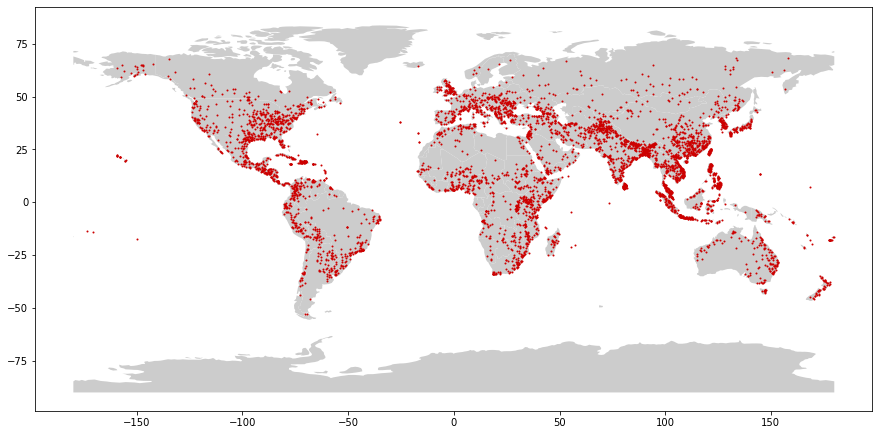

In [191]:
plot_flood_on_worldmap(flood_gdf)

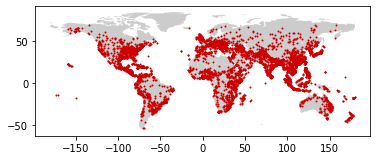

In [192]:
plot_flood_on_partial_worldmap(flood_gdf)

In [193]:
### Create a buffer of the GeoPandasDataFrame according to the area of the given flood

In [194]:
# Area in flood data is square km and input to function is the radii from the point so need to convert to radii
import math
flood_gdf['area_radii']=(flood_gdf['Area']/math.pi)
flood_gdf['area_radii']=flood_gdf['area_radii']**(1/2)
flood_gdf

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,Year,point_0,area_radii
0,1,0,Algeria,0,5.23026,35.81420,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,1985,POINT (5.23026 35.81420),171.698816
1,2,0,Brazil,0,-45.34890,-18.71110,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,1985,POINT (-45.34890 -18.71110),464.728826
2,3,0,Phillipines,0,122.97400,10.02070,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,1985,POINT (122.97400 10.02070),63.945433
3,4,0,Indonesia,0,124.60600,1.01489,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,1985,POINT (124.60600 1.01489),72.563905
4,5,0,Mozambique,0,32.34910,-25.86930,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,1985,POINT (32.34910 -25.86930),79.952273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,4947,NaN,Niger,Mali,1.16086,15.53690,390094.45,7/1/2020,7/30/2020,FloodList,9,15000,Heavy Rain,1.5,2020,POINT (1.16086 15.53690),352.378944
4946,4948,NaN,South Korea,NaN,127.05600,36.34890,23218.80,7/29/2020,7/30/2020,FloodList,2,0,Torrential Rain,1.5,2020,POINT (127.05600 36.34890),85.969608
4947,4950,NaN,Myanmar,NaN,96.26250,23.17430,46562.48,7/15/2020,7/30/2020,FloodList,0,6516,Monsoonal Rain,1.0,2020,POINT (96.26250 23.17430),121.742752
4948,4951,NaN,Japan,NaN,140.46700,38.49910,32493.26,7/27/2020,7/30/2020,FloodLIst,0,2500,Torrential Rain,1.5,2020,POINT (140.46700 38.49910),101.700176


In [195]:
# Multiply by 1000 to convert km to meters - buffering done in meters
#Create a buffer of the GeoPandas DataFrame according to the radii of the given flood
def buffer_area(df):
    df = df.set_geometry('point_0') #need to set geometry
    df= df.to_crs({'init':'epsg:3395'}) #need to change CRS system to meters for below calculation
    df['total_area'] = df.apply(lambda x: x.point_0.buffer(x['area_radii']*1000) , axis=1)  
    df = df.set_geometry('total_area')
    df= df.to_crs({'init':'epsg:4326'}) #change CRS system back to standard
    return df

In [196]:
buffer_gdf = buffer_area(flood_gdf)
buffer_gdf.head()

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,Year,point_0,area_radii,total_area
0,1,0,Algeria,0,5.23026,35.81420,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,1985,POINT (5.23026 35.81420),171.698816,"POLYGON ((1.54244 0.00032, 1.53502 -0.15188, 1..."
1,2,0,Brazil,0,-45.34890,-18.71110,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,1985,POINT (-45.34890 -18.71110),464.728826,"POLYGON ((4.17432 -0.00017, 4.15422 -0.41212, ..."
2,3,0,Phillipines,0,122.97400,10.02070,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,1985,POINT (122.97400 10.02070),63.945433,"POLYGON ((0.57554 0.00009, 0.57277 -0.05659, 0..."
3,4,0,Indonesia,0,124.60600,1.01489,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,1985,POINT (124.60600 1.01489),72.563905,"POLYGON ((0.65297 0.00001, 0.64983 -0.06431, 0..."
4,5,0,Mozambique,0,32.34910,-25.86930,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,1985,POINT (32.34910 -25.86930),79.952273,"POLYGON ((0.71851 -0.00023, 0.71506 -0.07111, ..."


In [218]:
#Copying into new dataframe helps reduce errors according to Omdena
gdf= gpd.GeoDataFrame(buffer_gdf, geometry='total_area')
print(gdf.crs)

None


In [40]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [224]:
#set src for new dataframe
gdf.crs = {'init': 'epsg:4326'}
print(gdf.crs)

{'init': 'epsg:4326'}


In [213]:
print(buffer_gdf.crs)

{'init': 'epsg:4326'}


In [202]:
type(gdf.geometry)

geopandas.geoseries.GeoSeries

In [225]:
#Interesting that this is such a smaller list than the floods list- but again I think unnecessary
affected_countries = gpd.overlay(gdf, world, how='intersection')
affected_countries

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,...,Severity,Year,point_0,area_radii,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,15,0,Brazil,0,-48.09870,-4.13519,1970402.21,4/2/1985,4/17/1985,News,...,2.0,1985,POINT (-48.09870 -4.13519),791.958650,24184810,Africa,Côte d'Ivoire,CIV,87120.0,"POLYGON ((-4.95958 5.12263, -4.51369 5.52773, ..."
1,308,0,Brazil,0,-38.15220,-7.19221,2734939.69,6/1/1989,6/26/1989,News,...,1.0,1989,POINT (-38.15220 -7.19221),933.037160,24184810,Africa,Côte d'Ivoire,CIV,87120.0,"POLYGON ((-7.07730 4.50189, -6.96940 4.68260, ..."
2,383,0,Brazil,0,-41.36960,-7.81604,2339268.40,12/10/1989,12/31/1989,News,...,1.0,1989,POINT (-41.36960 -7.81604),862.909183,24184810,Africa,Côte d'Ivoire,CIV,87120.0,"POLYGON ((-6.00998 4.92075, -5.99247 4.94443, ..."
3,513,0,China,0,110.25600,28.73460,1682864.93,5/18/1991,6/15/1991,News,...,2.0,1991,POINT (110.25600 28.73460),731.896539,24184810,Africa,Côte d'Ivoire,CIV,87120.0,"POLYGON ((-4.07771 5.17857, -3.65174 5.49524, ..."
4,638,0,Argentina,Brazil,-55.93950,-28.40990,1347809.74,4/1/1992,7/2/1992,News,...,2.0,1992,POINT (-55.93950 -28.40990),654.997072,24184810,Africa,Côte d'Ivoire,CIV,87120.0,"POLYGON ((-3.15481 4.98779, -2.83475 5.18016, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,3534,0,Mauritania,0,2.93676,16.45400,4814280.64,8/10/2009,9/2/2009,0,...,1.0,2009,POINT (2.93676 16.45400),1237.914828,1772255,Africa,Gabon,GAB,35980.0,"POLYGON ((11.12040 0.00015, 11.06686 -1.09712,..."
142,3534,0,Mauritania,0,2.93676,16.45400,4814280.64,8/10/2009,9/2/2009,0,...,1.0,2009,POINT (2.93676 16.45400),1237.914828,778358,Africa,Eq. Guinea,GNQ,31770.0,"POLYGON ((10.88610 2.26652, 10.90673 2.18371, ..."
143,3534,0,Mauritania,0,2.93676,16.45400,4814280.64,8/10/2009,9/2/2009,0,...,1.0,2009,POINT (2.93676 16.45400),1237.914828,4689021,Africa,Liberia,LBR,3881.0,"POLYGON ((-9.71376 5.42631, -9.24623 6.20759, ..."
144,3534,0,Mauritania,0,2.93676,16.45400,4814280.64,8/10/2009,9/2/2009,0,...,1.0,2009,POINT (2.93676 16.45400),1237.914828,24994885,Africa,Cameroon,CMR,77240.0,"POLYGON ((9.16824 6.31280, 9.24628 6.20759, 9...."


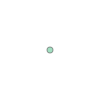

In [226]:
#Shows that the total_area is larger as it includes the buffer of the radii
gdf.loc[1,'point_0']

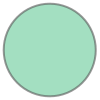

In [227]:
gdf.loc[1,'total_area']

In [231]:
#Helper function for getting flood year and country by ID
def get_flood_country_year_by_ID(ID):
    flood_country = floods.loc[floods.ID == ID].Country.values[0]
    flood_year = floods.loc[floods.ID == ID].Year.values[0]
    return flood_country, flood_year   

In [232]:
get_flood_country_year_by_ID(20)

('USA', 1985)

In [238]:
#collecting one flood (the first flood from the list)
a= gdf.total_area.tail(1)
type(a)
a.crs

{'init': 'epsg:4326'}

In [239]:
a

4949    POLYGON ((2.26361 0.00024, 2.25271 -0.22321, 2...
Name: total_area, dtype: geometry

In [240]:
type(a)

geopandas.geoseries.GeoSeries

In [279]:
#need to change from geopandas.geoseries.GeoSeries to a shape file (fiona.collection.Collection)
a.to_file(filename='exampleflood.shp', driver="ESRI Shapefile")

In [280]:
#assign this as text to new shape file
input_shape_file = 'exampleflood.shp'
shape= fiona.open('exampleflood.shp')
shape

<open Collection 'exampleflood.shp:exampleflood', mode 'r' at 0x1499e50>

In [281]:
print (shape.schema)

{'properties': OrderedDict([('id', 'int:18')]), 'geometry': 'Polygon'}


In [292]:
#check raster_file and input_raster_file
print(raster_file)
print(input_raster_file)

<open DatasetReader name='/Users/jswee/Documents/OFDA/Data Model/Population Data/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif' mode='r'>
C:\Users\jswee\datasets\Gridded Population of the World (GPW)\gpw_v4_population_count_rev11_2015_30_sec.tif


In [293]:
#both import_shape_file, shape and src give the same result with no errors
# both import_raster_file, and filename give the same with no errors
stats = ['sum']
with fiona.open(input_shape_file) as src:
    shape_file_crs = src.crs['init']
    print('shape file:'+ shape_file_crs)
    raster_file_crs = str(raster_file.crs).lower()
    print('raster file:'+ raster_file_crs)
    assert shape_file_crs == raster_file_crs
    result = zonal_stats(src, input_raster_file, stats = stats)

print (result)
population = result[0]['sum']
print ('Population affected by ' + input_shape_file.split('.')[0] + ' is: ' + str(population))

shape file:epsg:4326
raster file:epsg:4326
[{'sum': None}]
Population affected by exampleflood is: None


In [285]:
#Question 1 - why is this happening?? Files have no results and therefore aren't overlapping at all
stats= zonal_stats(shape, input_filename, all_touched=True)
stats

[{'count': 0, 'min': None, 'max': None, 'mean': None}]

In [ ]:
### NEXT STEPS ONCE I GET POPULATION AS SOMETHING

stats = ['sum']
for i in range (len(buffer_gdf)):
    population = zonal_stats(buffer_gdf.iloc[i].total_area, filename, stats = stats)
print (result)

    
#result = zonal_stats(src, input_raster_file, stats = stats)
#print (result)
#stats = ['sum']
#stats = ['min', 'max', 'mean', 'count', 
#              'sum', 'std', 'median', 'majority', 
#              'minority', 'unique', 'range']


In [287]:
for i in range (len(buffer_gdf)):
    print(buffer_gdf.iloc[i].total_area)

POLYGON ((1.542443689978041 0.0003238926919487549, 1.535016628259937 -0.1518761273935214, 1.512806969770015 -0.3026093111233016, 1.476028605660567 -0.4504230383139956, 1.425035731683067 -0.5938929809802072, 1.360319437089457 -0.731636889376863, 1.282502975174201 -0.8623279516662596, 1.192335761004346 -0.9847075944302013, 1.090686154142762 -1.097597598811055, 0.9785330958708529 -1.199911416002678, 0.8569566814488757 -1.290664575830228, 0.7271277582081422 -1.368984092965127, 0.5902966496511698 -1.434116786631809, 0.4477811141528545 -1.485436441230632, 0.3009536542269615 -1.522449746914295, 0.1512282985766313 -1.544800970670523, 4.698422498168149e-05 -1.552275319786281, -0.151134330126668 -1.544800970670523, -0.3008596857769983 -1.522449746914295, -0.4476871457028914 -1.485436441230632, -0.5902026812012069 -1.434116786631809, -0.7270337897581794 -1.368984092965127, -0.8568627129989134 -1.29066457583024, -0.9784391274208911 -1.199911416002678, -1.090592185692801 -1.097597598811055, -1.1922

POLYGON ((0.5230206085658208 -0.0003024953101959863, 0.5204990650468296 -0.05197560503202633, 0.51295871833236 -0.1031510323699277, 0.500472186083245 -0.1533358917546569, 0.4831597204308764 -0.202046844230887, 0.461188049883443 -0.2488147549748825, 0.4347687736392535 -0.2931892131911135, 0.4041563237707849 -0.3347428706983087, 0.3696455149047378 -0.373075557345834, 0.3315687049960195 -0.4078181336422112, 0.2902925945389525 -0.4386360435984828, 0.2462146950410554 -0.4652325337576566, 0.1997595007699241 -0.4873515076616059, 0.1513744006413818 -0.5047799885601701, 0.1015253696196526 -0.5173501669592467, 0.05069248112372811 -0.5249410135926232, -0.0006347163420924954 -0.5274794425532419, -0.0519619138079131 -0.524941013592636, -0.1027948023038377 -0.5173501669592467, -0.1526438333255668 -0.5047799885601701, -0.2010289334541092 -0.4873515076616059, -0.2474841277252406 -0.4652325337576566, -0.2915620272231378 -0.4386360435984828, -0.332838137680205 -0.4078181336422112, -0.3709149475889235 -0

POLYGON ((0.4380036978627303 0.000223061826246585, 0.4358984921772569 -0.04291818420143895, 0.4296031494024105 -0.08564393222241455, 0.4191782971304971 -0.1275426876674278, 0.4047243323876993 -0.1682109243684599, 0.386380454755831 -0.2072569723071326, 0.3643233258042708 -0.244304790701383, 0.3387653677424753 -0.2789975899993805, 0.3099527176779806 -0.3110012678544657, 0.2781628571815045 -0.3400076259997432, 0.2437019399877337 -0.3657373371037245, 0.2069018435674975 -0.3879426331429378, 0.168116972966302 -0.4064096895482489, 0.1277208476900036 -0.4209606823354808, 0.08610250450778148 -0.4314554985918318, 0.04366275081538096 -0.4377930840220352, 0.0008103046407891857 -0.4399124147331667, -0.0420421415338026 -0.4377930840220352, -0.08448189522620315 -0.4314554985918318, -0.1261002384084253 -0.4209606823354808, -0.1664963636847237 -0.4064096895482489, -0.2052812342859192 -0.3879426331429378, -0.2420813307061555 -0.3657373371037245, -0.2765422478999265 -0.3400076259997432, -0.30833210839640

POLYGON ((1.763277638591866 -0.0002284690513329954, 1.754793536146611 -0.1740899669935943, 1.729422935355276 -0.3462754877348236, 1.687410168972462 -0.5151253341748033, 1.629159842904951 -0.6790121964548682, 1.555232939635639 -0.8363569266600815, 1.466341415655567 -0.9856438181688, 1.363341344933712 -1.125435236363948, 1.247224674456693 -1.254385456918444, 1.119109671237031 -1.371253578995639, 0.9802301527905157 -1.47491539305612, 0.8319236047990559 -1.564374096117594, 0.6756183003924148 -1.638769760884114, 0.5128195450971991 -1.697387478801752, 0.3450951799217541 -1.739664110539314, 0.1740604821901837 -1.765193590450402, 0.001362609538719542 -1.773730744151791, -0.1713352631127447 -1.765193590450402, -0.342369960844315 -1.739664110539326, -0.5100943260197602 -1.697387478801752, -0.672893081314976 -1.638769760884114, -0.8291983857216175 -1.564374096117607, -0.9775049337130778 -1.47491539305612, -1.116384452159593 -1.371253578995639, -1.244499455379256 -1.254385456918444, -1.36061612585

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



POLYGON ((0.5517962994158777 -0.0001257950056703752, 0.5491407268893187 -0.05454551361439579, 0.5411995839247562 -0.1084410915564131, 0.5280493480700089 -0.1612934403290313, 0.5098166632850086 -0.2125935263183523, 0.4866771202912339 -0.2618472762617935, 0.458853565537076 -0.3085803376308046, 0.4266139550647194 -0.3523426479381618, 0.3902687739469769 -0.3927127688761557, 0.3501680461463092 -0.4293019435633849, 0.3066979635927245 -0.4617578379502063, 0.260277166944378 -0.4897679305696681, 0.2113527138491822 -0.5130625182830282, 0.1603957735352705 -0.5314173094179061, 0.1078970891937627 -0.5446555796918161, 0.05436225185356769 -0.5526498705137275, 0.000306831263390607 -0.5553232136224344, -0.0537485893267865 -0.5526498705137275, -0.1072834266669815 -0.5446555796918161, -0.1597821110084894 -0.5314173094179061, -0.2107390513224012 -0.5130625182830282, -0.259663504417597 -0.4897679305696681, -0.3060843010659436 -0.4617578379502063, -0.3495543836195285 -0.4293019435633849, -0.3896551114201964

POLYGON ((2.78934897430493 0.000172865702996673, 2.775921107734118 -0.2749986776084479, 2.735766825717176 -0.5475138536651812, 2.669272835940492 -0.8147424182083086, 2.577079511874927 -1.074106082503994, 2.46007472562923 -1.323103751385102, 2.319385297256269 -1.559335892622693, 2.156366142859941 -1.780527778637394, 1.972587226012417 -1.984551365378607, 1.769818438146714 -2.169445600233248, 1.550012553534673 -2.333434979606502, 1.315286423003227 -2.474946205887445, 1.067900587503749 -2.592622821546679, 0.8102375078669544 -2.685337724017926, 0.5447786204027105 -2.752203488005599, 0.274080439311888 -2.792580441513891, 0.0007499360570695845 -2.806082458158184, -0.2725805671977489 -2.792580441513891, -0.5432787482885715 -2.752203488005599, -0.8087376357528155 -2.685337724017926, -1.066400715389611 -2.592622821546679, -1.313786550889088 -2.474946205887445, -1.548512681420535 -2.333434979606502, -1.768318566032577 -2.16944560023326, -1.971087353898281 -1.984551365378607, -2.154866270745807 -1

In [ ]:
def get_population_by_ID(ID):
    raster_file = src
    flood_data = []
    for i in range (len(buffer_gdf)):   
        flood = {}
        country = buffer_gdf.iloc[i]['Country']
        population = zonal_stats(buffer_gdf.iloc[i].total_area, src, stats = ['sum'])
        flood['ID']= ID
        flood['country'] = country
        flood['pop'] = population   
        flood_data.append(flood)
    return flood_data, raster_file

In [ ]:
get_population_by_ID(20)

In [ ]:
def get_population_by_ID(ID):    
    #single_flood_data = []
    #flood_df = df_input[(df_input.ID==ID)].copy()
    #flood_gdf = create_flood_gdf(flood_df)
        for i in range len(buf_gdf):
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID,affected_countries, windspeed)
        #single_cyclone_data.extend(cyclone_data_windspeed)
        #print(cyclone_data_windspeed)
    #return single_cyclone_data, raster_year

In [ ]:
#buffer_gdf = buf_gdf
flood_data = []  
error_flood = [] 
for i in range len(buf_gdf):       ## Change here to get output for all cyclones
    cyclone_ID = (cyclones.iloc[i]['ID'])
    try:
        cyclone_population, raster_year = get_population_by_SID(cyclone_ID)
        flood_data.extend(cyclone_population)
    except:
        error_flood.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(flood_data)


In [ ]:
cyclone_data = []
error_cyclone = []
#for i in range (10):                  
for i in range (len(cyclones)):             ## Change here to get output for all cyclones
    cyclone = {}
    cyclone_SID = (cyclones.iloc[i]['SID'])
    cyclone_name = (cyclones.iloc[i]['NAME'])
    cyclone_year = (cyclones.iloc[i]['SEASON'])
    print(f'{i}/{len(cyclones)} Getting population for:{cyclone_SID}-{cyclone_name}-{cyclone_year}')
    try:
        cyclone_population, raster_year = get_population_by_SID(cyclone_SID)
        cyclone_data.extend(cyclone_population)
        print(f'Rasterfile: {raster_year}')
        print('--------------------------------------------')
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['SID','NAME','SEASON', 'COUNTRY'], as_index = False).sum()

In [ ]:
for poly in buffer_gdf['total_area']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='grey', alpha=0.25, linewidth=0.1)

In [ ]:
for flood in buffer_gdf['total_area']:
    #gpd.plotting.plot_multipolygon(ax, poly, linewidth=0.1, edgecolor='grey')
    gpd.overlay(world, flood, how='intersection')

In [ ]:
#checking geometry types of world and buffer_gdf
world['geometry'].geom_type

In [ ]:
buffer_gdf['total_area'].geom_type

In [ ]:
#find overlay of affected countries from floods
#cyclone data used shape of individual cyclone - will this work for all floods?
affected_countries = gpd.overlay(world, max_shape, how='intersection')
affected_countries

In [ ]:
 for i in range (len(buffer_gdf)):   
        buffer_gdf['affected_countries'].iloc[i] = gpd.overlay(buffer_gdf['total_area'].iloc[i], world, how='intersection')

In [ ]:
buffer_gdf['total_area'].iloc[i].geom_type

In [ ]:
world.geom_type

In [ ]:
affected_countries = gpd.overlay(world, a, how='intersection')
affected_countries

In [ ]:
a=buffer_gdf.tail(1)
a= a.drop(['ID','GlideNumber','center_shape', 'Country','OtherCountry','Severity','Year','Validation','Dead', 'Displaced','MainCause','Area','Began','Ended', 'long','lat','point_0','area_radii'], axis=1)
a=a.rename(columns={'total_area': 'geometry'})
a

In [ ]:
max_shape

In [ ]:
from shapely.geometry import mapping

In [ ]:
buffer_gdf2= [mapping(a)]